# Differential Microbiome Composition in Vegetarians and Non-Vegetarians: Insights into Sulfoquinovose Degradation Pathways


To identify organisms capable of degrading sulfoquinovose (SQ), we collected metadata and amino acid sequences of enzymes involved in SQ degradation from the following sources:

1. [MetaCyc](https://metacyc.org/) - General pathway and enzyme database

2. [Uniprot](https://www.uniprot.org/) - Curated protein sequences with experimental evidence (filtered to exclude predicted/in silico entries).

3. [SQ degradation pathways: EMP-1,2; TK; TAL; SD; ASMO (Li et al., 2022)](https://pmc.ncbi.nlm.nih.gov/articles/PMC9594981/) - Literature supporting five proposed SQ metabolic pathways.

4. [Additional SQ degradation pathway](https://pmc.ncbi.nlm.nih.gov/articles/PMC10507154/) - 6th ASDO pathway

After collecting the sequences and their annotations, we used **JackHMMER** and **DIAMOND** (with _sensitive_ mode) to identify SQ-degrading proteins in the Unified Human Gastrointestinal Protein (UHGP) database (using 100% cluster identity threshold).

In [ ]:
# jackhmmer execution command line
code/bin/jackhmmer.sh

In [ ]:
# Diamond execution command line
code/bin/diamond.sh

When executaion is complete, we investigate the possible homologes from jackhmmer and Diamond.

## Import Packages

In [ ]:
# For exploring the datasets (jkhmmer, diamond outputs )
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# For plotting represent locus
from dna_features_viewer import GraphicFeature, GraphicRecord

# For Parsing hmmer output & gff files from UGHP
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqRecord import SeqRecord
from io import StringIO
from re import search, compile

# For Pathway Defining
import networkx as nx
from collections import defaultdict

# For OLS
import statsmodels.formula.api as smf

## Genome metadata from UGHP

In [2]:
genome_metadata = pd.read_csv('genomes-all_metadata.tsv', sep='\t')
genome_metadata['Species'] = genome_metadata['Lineage'].str.split(';').str[-1]
genome_metadata['Phylum'] = genome_metadata['Lineage'].str.split(';').str[1]
genome_metadata['Class'] = genome_metadata['Lineage'].str.split(';').str[2]
genome_metadata.loc[genome_metadata['Phylum'].str.contains('Firmicutes', na=False), "Phylum"] = 'p__Firmicutes'

## **Parsing Diamond Blastp Output**
- query `SQ_degradation.fasta`
- subject `uhgp-100.faa`
    - subject index `uhgp-100.dmnd`
- output `SQD_uhgp100.tsv`


In [ ]:
diamond_output = pd.read_csv('SQD_uhgp100.tsv',
                 sep='\t',
                 names="qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore".split()
                ) # read csv file and give the columns names
seq_description = pd.read_csv('sq_enzymes_metadata.csv')
seq_description = seq_description.rename(columns={'id_seq': 'qseqid'})
seq_description['qseqid'] = seq_description['qseqid'].str.replace(' ', '') # Remove whitespaces from query sequence
seq_description = seq_description[['qseqid', 'enzyme', 'defining', 'Pathway_all', 'gene_name']]
seq_description = seq_description.drop_duplicates()
diamond_output = diamond_output.drop_duplicates()
diamond_output['AligningTool'] = 'Diamond'
# Extract length
rows = []
for record in SeqIO.parse('../data/SQ_degradation_enzymes.fasta', 'fasta'):
    row = {
        "qseqid": record.id,
        "query_length": len(record.seq)
        }
    rows.append(row)
seqid_length = pd.DataFrame(rows)
diamond_output = diamond_output.merge(seqid_length, how='left').merge(seq_description, how='left')
diamond_output['query_cover'] = diamond_output['length'] / diamond_output['query_length']

<Axes: xlabel='query_cover', ylabel='pident'>

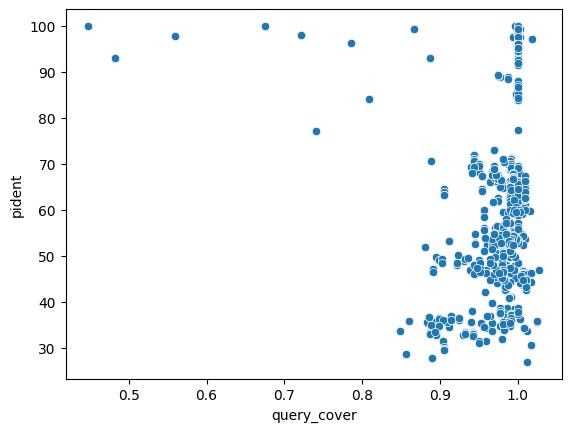

In [6]:
sns.scatterplot(diamond_output, x='query_cover', y='pident') # lets see scatterplot of query cover and pident

Based on PubMed literature analysis, we hypothesize that enzymes exhibiting even partial similarity to experimentally characterized SQ-degrading enzymes may have functional relevance. Therefore, for DIAMOND BLASTp alignments, we applied the following conservative thresholds:

    - Query coverage: ≥40%

    - Percent identity: ≥30%

## **Parsing Jakchmmer output**
- query `SQ_degradation.fasta`
- subject `uhgp-100.fasta`
    - subject index `uhgp-100.dmnd`
- output `SQD_uhgp100.tsv`


In [ ]:
def convert_tbl_to_dataframe(tbl_file_path: str) -> pd.DataFrame:
    """
    This function convert hmmer table output to pandas DataFrame
    """
    rows = []
    for query_result in SearchIO.parse(tbl_file_path, "hmmer3-tab"):
        for hit in query_result.hits:
            for hsp in hit.hsps:
                # extract all relevant information
                row = {
                    "query_id": query_result.id,
                    "hit_id": hit.id,
                    "hit_description": hit.description,
                    "evalue_hit_level": hit.evalue,
                    "bitscore_hit_level": hit.bitscore,
                    "bias_hit_level": hit.bias,
                    "domain_evalue": hsp.evalue,
                    "domain_bitscore": hsp.bitscore,
                    "domain_bias": hsp.bias,
                    'bias_best_domain': hsp.bias,
                    'bitscore_best_domain': hsp.bitscore,
                    'evalue_best_domain': hsp.evalue,
                    'domain_obs_num': hit.domain_obs_num, #dom
                    'domain_included_num': hit.domain_included_num, #inc
                    'domain_reported_num': hit.domain_reported_num, #rep
                    'domain_exp_num': hit.domain_exp_num, # exp
                    'cluster_num': hit.cluster_num, # clu
                    'env_num': hit.env_num, #env
        }
                rows.append(row)
    return pd.DataFrame(rows)
convert_tbl_to_dataframe('jackhmmer_result.tsv').to_csv('hmmer_result.converted.csv', index=False)

Text(0.5, 1.0, 'Distibution of Evalue')

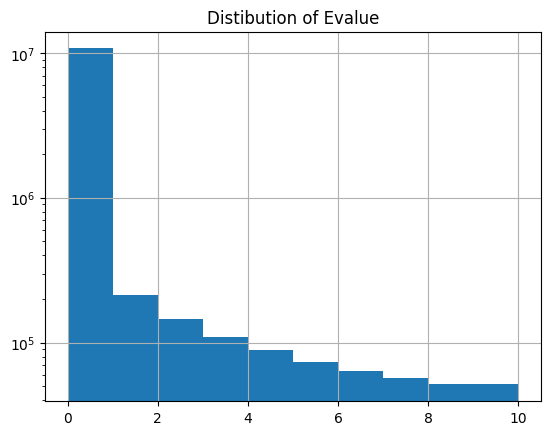

In [8]:
hmmer_df = pd.read_csv('hmmer_result.converted.csv')
hmmer_df['evalue_hit_level'].hist()
plt.yscale('log')
plt.title('Distibution of Evalue')

We applied the following thresholds to process JackHMMER outputs:
   - E-value (hit level): ≤1e-3

   - Bias (hit level): <5

   - Minimum domains included: ≥1

In [ ]:
# --- Filter JACKHMMER output ---
hmmer_df_filter = hmmer_df[(hmmer_df['evalue_hit_level'] <= 1e-3) & (hmmer_df['domain_included_num'] >= 1) & (hmmer_df['bias_hit_level'] < 5)] # Threshold
hmmer_df_filter = hmmer_df_filter.drop_duplicates()
seq_description = seq_description.rename(columns={'qseqid':'query_id'})
hmmer_df_filter = hmmer_df_filter.merge(seq_description, how='left')

In [ ]:
# --- Normalize DIAMOND column names for merge ---
diamond_output_renamed = diamond_output.rename(columns={
    'qseqid': 'query_id',
    'sseqid': 'hit_id',
    'evalue': 'evalue_hit_level',
    'bitscore': 'bitscore_hit_level'
})

# --- Merge both annotations ---
combined_hits = pd.concat([hmmer_df_filter, diamond_output_renamed], ignore_index=True)
combined_hits['AligningTool'] = combined_hits['AligningTool'].fillna("JackHMMER")

# Drop unneeded alignment metadata (optional but reduces noise)
drop_cols = ['qstart', 'qend', 'sstart', 'send', 'length', 'mismatch', 'query_length']
combined_hits = combined_hits.drop(columns=[col for col in drop_cols if col in combined_hits.columns])

# --- Extract genome ID from hit_id ("MGYGxxxxx") ---
combined_hits['Genome'] = combined_hits['hit_id'].str.extract(r'(MGYG\d+)')

# Handle inconsistent genome IDs (some use ".1" suffix in UHGP)
missing_genomes = ~combined_hits['Genome'].isin(genome_metadata['Genome'])
combined_hits.loc[missing_genomes, 'Genome'] = combined_hits.loc[missing_genomes, 'Genome'] + '.1'

# --- Merge with genome metadata ---
combined_hits = combined_hits.merge(genome_metadata[['Genome', 'Lineage']], how='left')

# Optional: Save merged annotations
# combined_hits.to_csv('Combined_Annotations_With_Meta.csv', index=False)


/tmp/ipykernel_967168/2900529491.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  combined_annotations = hmmer_df_filter.merge(diamond_output, how='outer')


## Explore Annotations Result

We first selected core enzymes specific to major SQ degradation pathways (EMP, TK, ASMO, TAL, ASDO), then we identified additional essential enzymes (yihQ, yihS, yihR etc.) shared across multiple metabolic pathways.

In [ ]:
# --- Define list of known SQ transporter-related genes ---
transport_genes = [
    '7NBZ_A', 'WP_009065225.1', 'WP_017965793.1',
    'tauD', 'smoF', 'csqR', np.nan  # np.nan included to catch empty annotations
]

# --- Split into two DataFrames: transporters and core enzymes ---
SQD_transporters = combined_hits[combined_hits['gene_name'].isin(transport_genes)]
SQD_enzymes = combined_hits[~combined_hits['gene_name'].isin(transport_genes)]

# Optional export
# SQD_transporters.to_csv('SQD_transport_genes.csv', index=False)
# SQD_enzymes.to_csv('SQD_degradation_enzymes.csv', index=False)

# --- Final cleanup for enzymes ---
# Fill missing pathway labels with a generic one
SQD_enzymes.loc[SQD_enzymes["defining"].isna(), 'Pathway_all'] = 'Shared pathway'

# Rename for clarity
SQD_enzymes = SQD_enzymes.rename(columns={'Pathway_all': 'Pathway'})

# Keep best hit per protein (lowest e-value)
SQD_enzymes = (
    SQD_enzymes
    .sort_values('evalue_hit_level')
    .drop_duplicates(subset='hit_id', keep='first')
)


In [ ]:
# -- If memory limit exceed --
del(diamond_output)
del(hmmer_df)
del(hmmer_df_filter)
del(combined_hits)

In [ ]:
# -- Cluster Info --
hit_mapping = pd.read_csv('clustered_hits.tsv', names=['hit_id', 'clsutered_hits'], sep='\t'
SQD_enzymes = hit_mapping.merge(SQD_enzymes, how='left'))

In [ ]:
GenePathGroups = SQD_enzymes.groupby(['Pathway', 'gene_name']).agg({'Genome':'nunique'})
GenePathGroups = GenePathGroups.reset_index()
GenePathGroups_pivot = GenePathGroups.pivot_table(index='Pathway', columns='gene_name', values='Genome', aggfunc='sum')

# Build Stack bars
GenePathGroups_pivot.plot(kind='bar', stacked=True)
plt.xlabel("Pathway")
plt.ylabel("Number of genomes")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [ ]:
# Save hits for find local groups in genomes
# Hits = SQD_enzymes[['hit_id', 'Genome', 'gene_name']] 
# Hits.to_csv('hits.csv', index=False)

 - [Human Gastrointeral Genomes](ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/) - Link for downloading GFF files

To identify locally clustered gene groups, we developed an automated scripts: [FindLocalGroup](HitsDir.GFF/FindLocalGroup.py) that scans and analyzes genomic feature (GFF) files for co-localized genetic elements and [ExtractLocalGroup](ExtractLocalGroup.py) witch extracting. The *window* beetwen genes was 5000bp

In [ ]:
code/bin/FindLocalGroup.py ../data/hits.csv <<Path/to/dir/with/gff/files>>

In [ ]:
code/bin/ExtractLocalGroup.py <<Path/to/FLGResult/dirr>>

## Define Pathway

In [85]:
gff_groups = pd.read_csv('HitsDir.GFF/LocalGroups.tsv', sep='\t')
gff_groups['co_genes'] = gff_groups['co_genes'].str.replace(' ', '')
gff_groups['co_genes'] = gff_groups['co_genes'].str.replace('smol', 'yihQ')
gff_co_genes = gff_groups.dropna().co_genes.str.split(',').apply(lambda x: set(x))
gff_co_genes = gff_co_genes.drop_duplicates()
gff_co_genes = gff_co_genes.to_frame()

In [ ]:
# --- Evaluate Path Completness ---
pathway_reactions = [
    # SQpro → SQalpha
    ("SQpro", "SQalpha", "YihQ", "yihQ"),
    ("SQpro", "SQalpha", "SqgA", "sqgA"),

    # SQalpha → SQbeta
    ("SQalpha", "SQbeta", "YihR", "yihR"),

    # SQbeta → ED
    ("SQbeta", "SG-L", "SedA", "sedA"),
    ("SG-L", "KDSG", "SedC", "sedC"),
    ("KDSG", "Pyruvate", "SedD", "sedD"),

    # SQbeta → SF
    ("SQbeta", "SF", "SqvD/YihS", ("sqvD", "yihS")),

    # SF → TK
    ("SF", "SE", "SqwGH", ("sqwG", "sqwH")),
    ("SE", "SEu", "SqwI", "sqwI"),
    ("SEu", "SA", "SqwGH", ("sqwG", "sqwH")),

    # SF → TAL
    ("SF", "SLA", "SqvA", "sqvA"),

    # SF → EMP
    ("SF", "SF-1P", "YihV/SqiK", ("yihV", "sqiK")),
    ("SF-1P", "DHAP/SLA", "YihT/SqiA", ("yihT", "sqiA")),
]

G = nx.DiGraph()
for substrate, product, enzyme, gene in pathway_reactions:
    if isinstance(gene, tuple):
        G.add_edge(substrate, product, enzyme=enzyme, genes=set(gene))
    else:
        G.add_edge(substrate, product, enzyme=enzyme, genes={gene})

reaction_to_pathways = defaultdict(list)
pathway_definitions = {
    "SQpro": [("SQpro", "SQalpha")],
    "SQalpha": [("SQalpha", "SQbeta")],
    "Sulfo-ED": [("SQbeta", "SG-L"), ("SG-L", "KDSG"), ("KDSG", "Pyruvate")],
    "SQbeta": [("SQbeta", "SF")],
    "Sulfo-TK": [("SF", "SE"), ("SE", "SEu"), ("SEu", "SA")],
    "Sulfo-TAL": [("SF", "SLA")],
    "Sulfo-EMP": [("SF", "SF-1P"), ("SF-1P", "DHAP/SLA")]
}
for pathway, reactions in pathway_definitions.items():
    for r in reactions:
        reaction_to_pathways[r].append(pathway)

def annotate_locus(locus):
    pathway_coverage = defaultdict(lambda: [0, 0])  # [covered, total]

    for u, v, data in G.edges(data=True):
        genes = data['genes']
        covered = bool(genes & locus)
        data['covered'] = covered

        for pathway in reaction_to_pathways.get((u, v), []):
            pathway_coverage[pathway][1] += 1
            if covered:
                pathway_coverage[pathway][0] += 1

    pathway_results = {
        path: {
            "ratio": cov / total if total else 0,
            "locus": locus
        }
        for path, (cov, total) in pathway_coverage.items()
    }

    return pathway_results

# --- Annotate DF and get pathway ratio ---
def annotate_dataframe(df, gene_column="co_genes"):
    all_pathways = list(pathway_definitions.keys())

    def get_ratios(locus_genes):
        result = annotate_locus(locus_genes)
        return {path: result.get(path, {"ratio": 0})["ratio"] for path in all_pathways}

    ratios_df = df[gene_column].apply(get_ratios).apply(pd.Series)
    return pd.concat([df, ratios_df], axis=1)




In [87]:
gff_co_genes = annotate_dataframe(gff_co_genes)
gff_co_genes['co_genes'] = gff_co_genes['co_genes'].apply(lambda x:','.join(x))

There we find a full prescence of core SQ-degradation  genes in loci

In [88]:
# --- Core Genes Threshold ---
gff_co_genes['EMPmin'] = (gff_co_genes['SQbeta'] == 1) & (gff_co_genes['Sulfo-EMP'] == 1)
gff_co_genes['TKmin'] = (gff_co_genes['SQbeta'] == 1) & (gff_co_genes['Sulfo-TK'] == 1)
gff_co_genes['TALmin'] = (gff_co_genes['SQbeta'] == 1) & (gff_co_genes['Sulfo-TAL'] == 1)
gff_co_genes['EDmin'] = (gff_co_genes['SQpro'] == 1) & (gff_co_genes['Sulfo-ED'] == 1)
gff_co_genes = gff_co_genes[gff_co_genes['EDmin'] | gff_co_genes['EMPmin'] | gff_co_genes['TALmin'] | gff_co_genes['TKmin']]
gff_groups['co_genes'] = gff_groups.co_genes.str.split(',').apply(lambda x: set(x))
gff_groups['co_genes'] = gff_groups['co_genes'].apply(lambda x:','.join(x))
gff_groups = gff_groups.dropna()

# --- Merge with our gff groups ---
gff_locus_meta = gff_groups.merge(gff_co_genes, how='left', on='co_genes')
gff_locus_meta = gff_locus_meta.dropna()

# Define pathway
pathway_flags = ['EMPmin', 'TKmin', 'TALmin', 'EDmin']

gff_locus_meta['Pathway'] = gff_locus_meta[pathway_flags] \
    .apply(lambda row: ','.join([col.replace('min', '') for col in row.index if row[col]]), axis=1)

gff_locus_meta['Pathway'].value_counts()

Pathway
TK         58167
EMP        19538
TAL        18845
TK,TAL      2279
EMP,TK       357
EMP,TAL       63
ED             5
Name: count, dtype: int64

In [108]:
gff_locus_meta = gff_locus_meta.merge(genome_metadata[['Genome', "Species_rep", "Lineage",
                                                       'Phylum', 'Class', 'Species']],
                                                        how='left')



# Prescence of locus across specie
genome_metadata_groupby_species = genome_metadata.groupby('Species_rep').agg({'Genome':'nunique'}).rename(columns={'Genome':'TotalGenomesInSpecies'}).reset_index()
co_located_genomes = gff_locus_meta.groupby(['Species_rep', 'co_genes']).agg({'Genome':'nunique'}).rename(columns={'Genome':'GenomesWithThisLocus'}).reset_index()
gff_locus_meta = gff_locus_meta.groupby(['genome_region', 'co_genes']).agg({
                                         'start': 'min',
                                         'stop': 'max',
                                         'Genome': 'first',
                                         'Pathway': 'first',
                                         'Species_rep': 'first',
                                         'Lineage' : 'first',
                                         'Phylum': 'first',
                                         'Class': 'first',
                                         'Species': 'first',
                                         'Lineage': 'first'
                                                          }).reset_index()

locus_groups_meta = gff_locus_meta.merge(co_located_genomes, how='left').merge(genome_metadata_groupby_species, how='left')
locus_groups_meta['GenomeFractionWithLocus'] = locus_groups_meta['GenomesWithThisLocus'] / locus_groups_meta['TotalGenomesInSpecies']
locus_groups_meta.to_csv('locus_groups.csv', index=False)


## Retrieve SQ degradation locuses

In [ ]:
exctractlocuses.py # extract fasta SQ clusters with 1000bp wings

In [ ]:
code/bin/mmseq_cluster.sh # cluster locus

### Retrive Locuses with sulfoquinovosidase (Additional, not necessary)

In [ ]:
# --- Subset with SQDsidase locus ---
sq_locus_dataframe = pd.read_csv('locus_groups.csv')
sq_locus_dataframe = sq_locus_dataframe[sq_locus_dataframe['co_genes'].str.contains(r'yihQ|sqgA|smol')]

In [ ]:
with open('SQDsidase_locuses.fasta', 'a') as output_handle: 
    for record in SeqIO.parse('MMSEQ_clustering/SQD_locus.fasta', 'fasta'):
        if 'yihQ' in record.description or 'sqgA' in record.description:
                SeqIO.write(record , output_handle, 'fasta')

## Retrieve cluster sequence for mapping

### Retrieve SQsidase cluster loci

In [112]:
Sequence_cluster = pd.read_csv('MMSEQ_clustering/SQD_095_08.tsv', sep='\t', names=['cluster', 'element']) # cluster seqs on 95 min identity and covarage 80
Sequence_cluster['genome_region'] = Sequence_cluster['element'].str.extract(r'(MGYG[0-9_.fa]+)')
locus_meta = pd.read_csv('locus_groups.csv')
Sequence_cluster = Sequence_cluster.merge(locus_meta, how='left')
ClusterGroups = Sequence_cluster.groupby(['cluster', 'co_genes']).agg({'element':'nunique', "Species":'nunique'})
Sequence_cluster['Length'] = Sequence_cluster['stop'] - Sequence_cluster['start']
Sequence_cluster = Sequence_cluster.drop_duplicates('cluster')

# Retrieve clustered Sequnce
with open('MMSEQ_clustering/SQDsidase_locuses.fasta') as fastafile, open('SQDsidase_locus_for_mapping.fasta', 'a') as output_fasta:
    for record in SeqIO.parse(fastafile, 'fasta'):
        if record.id in Sequence_cluster['cluster'].to_list():
            SeqIO.write(record, output_fasta, 'fasta')
Sequence_cluster.to_csv('SQDsidase_locus_for_mapping_metadata.csv', index=False) 

### Retrieve cluster loci with min threshold on core genes

In [ ]:
Sequence_cluster = pd.read_csv('MMSEQ_clustering/SQD_095_08.tsv', sep='\t', names=['cluster', 'element']) # cluster seqs on 95 min identity and coverage 80
Sequence_cluster['genome_region'] = Sequence_cluster['element'].str.extract(r'(MGYG[0-9_.fa]+)')

# locus_meta 
locus_meta = pd.read_csv('locus_groups.csv')

Sequence_cluster = Sequence_cluster.merge(locus_meta, how='left')
Sequence_cluster['Length'] = Sequence_cluster['stop'] - Sequence_cluster['start']
ClusterGroups = Sequence_cluster.groupby('cluster').agg({'co_genes':'nunique', 'element':'size', 'TotalGenomesInSpecies':'first'})
SpeciesLocusGroups = Sequence_cluster.groupby(['Species', 'co_genes']).agg({'cluster':'nunique', 'element':'size', 'TotalGenomesInSpecies': 'first'})

# ---Save metadata for AGP mapping---
with open('MMSEQ_clustering/SQD_locuses.fasta') as fastafile, open('SQD_locus_for_mapping.fasta', 'a') as output_fasta:
    for record in SeqIO.parse(fastafile, 'fasta'):
        if record.id in Sequence_cluster['cluster'].to_list():
            SeqIO.write(record, output_fasta, 'fasta')
Sequence_cluster.to_csv('LocusMetadata.csv', index=False)

## Plotting the Locus

In [159]:
locus_meta[locus_meta.Lineage.str.contains('Escherichia')]

,genome_region,co_genes,start,stop,Genome,Pathway,Species_rep,Lineage,Phylum,Class,Species,GenomesWithThisLocus,TotalGenomesInSpecies,GenomeFractionWithLocus
376,MGYG000006234.fa_11,"yihS,yihV,yihT,yihU,yihR,yihQ",105322.0,112588.0,MGYG000006234,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323
1581,MGYG000024222_31,"yihS,yihV,yihT,yihU,yihR,yihQ",36268.0,43534.0,MGYG000024222,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323
1856,MGYG000028237_53,"yihS,yihV,yihT,yihU,yihR,yihQ",18676.0,25942.0,MGYG000028237,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323
2487,MGYG000038063_11,"yihS,yihV,yihT,yihU,yihR,yihQ",91506.0,99660.0,MGYG000038063,EMP,MGYG000002507,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia albertii,1,11,0.090909
4867,MGYG000072444_171,"yihS,yihV,yihT,yihU,yihR",909.0,5941.0,MGYG000072444,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,1,8314,0.000120
4883,MGYG000072724_184,"yihT,yihV,yihS,yihU",999.0,5105.0,MGYG000072724,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,2,8314,0.000241
7446,MGYG000109795_48,"yihS,yihV,yihT,yihU,yihR,yihQ",103466.0,110732.0,MGYG000109795,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323
11823,MGYG000174053_2,"yihS,yihV,yihT,yihU,yihR,yihQ",103454.0,110720.0,MGYG000174053,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323
11928,MGYG000175656_11,"yihS,yihV,yihT,yihU,yihR,yihQ",103430.0,110696.0,MGYG000175656,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323
15575,MGYG000230391_11,"yihS,yihV,yihT,yihU,yihR,yihQ",103430.0,110696.0,MGYG000230391,EMP,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria,c__Gammaproteobacteria,s__Escherichia coli_D,11,8314,0.001323


In [165]:
groups = pd.read_csv('HitsDir.GFF/FLGResult/MGYG000006234.groups.tsv', sep='\t')
groups[groups['co_genes'].str.contains('yihQ', na=False)]

,genome_region,start,stop,strand,features,protein_id,gene_name,midpoint,co_genes
373,MGYG000006234.fa_11,105322.0,106218.0,-,ID=MGYG000006234_00156;eC_number=2.7.1.184;Nam...,MGYG000006234_00156,yihV,105770.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
374,MGYG000006234.fa_11,106386.0,107282.0,+,ID=MGYG000006234_00157;eC_number=1.1.1.373;Nam...,MGYG000006234_00157,yihU,106834.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
375,MGYG000006234.fa_11,107306.0,108184.0,+,ID=MGYG000006234_00158;eC_number=4.1.2.57;Name...,MGYG000006234_00158,yihT,107745.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
376,MGYG000006234.fa_11,108200.0,109384.0,+,ID=MGYG000006234_00159;eC_number=5.3.1.31;Name...,MGYG000006234_00159,yihS,108792.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
377,MGYG000006234.fa_11,109452.0,110354.0,+,ID=MGYG000006234_00160;Name=yihR;db_xref=COG:C...,MGYG000006234_00160,yihR,109903.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
378,MGYG000006234.fa_11,110552.0,112588.0,+,ID=MGYG000006234_00161;eC_number=3.2.1.199;Nam...,MGYG000006234_00161,yihQ,111570.0,"yihV, yihU, yihT, yihS, yihR, yihQ"


In [166]:
locus_subset = groups[373:379]
locus_subset

,genome_region,start,stop,strand,features,protein_id,gene_name,midpoint,co_genes
373,MGYG000006234.fa_11,105322.0,106218.0,-,ID=MGYG000006234_00156;eC_number=2.7.1.184;Nam...,MGYG000006234_00156,yihV,105770.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
374,MGYG000006234.fa_11,106386.0,107282.0,+,ID=MGYG000006234_00157;eC_number=1.1.1.373;Nam...,MGYG000006234_00157,yihU,106834.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
375,MGYG000006234.fa_11,107306.0,108184.0,+,ID=MGYG000006234_00158;eC_number=4.1.2.57;Name...,MGYG000006234_00158,yihT,107745.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
376,MGYG000006234.fa_11,108200.0,109384.0,+,ID=MGYG000006234_00159;eC_number=5.3.1.31;Name...,MGYG000006234_00159,yihS,108792.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
377,MGYG000006234.fa_11,109452.0,110354.0,+,ID=MGYG000006234_00160;Name=yihR;db_xref=COG:C...,MGYG000006234_00160,yihR,109903.0,"yihV, yihU, yihT, yihS, yihR, yihQ"
378,MGYG000006234.fa_11,110552.0,112588.0,+,ID=MGYG000006234_00161;eC_number=3.2.1.199;Nam...,MGYG000006234_00161,yihQ,111570.0,"yihV, yihU, yihT, yihS, yihR, yihQ"


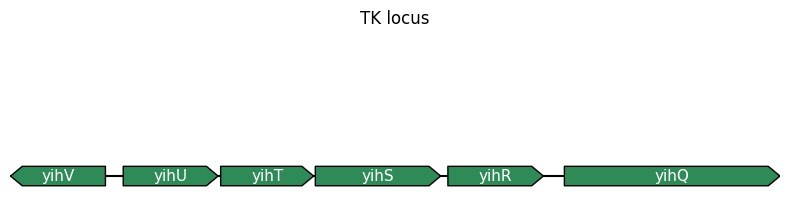

In [167]:
def plot_locus(locus_subset, locus_name = None):
    features = []
    locus_subset = locus_subset.fillna('')
    for index,rows in locus_subset.iterrows():
        feature = GraphicFeature(
            start=rows['start'],
            end=rows['stop'],
            label=rows['gene_name'],
            strand=-1 if rows['strand'] == '-' else +1,
            color='coral' if rows['gene_name'] == '' else "seagreen"
        )
        features.append(feature)

    locus_record = GraphicRecord(sequence_length=locus_subset['stop'].max()+3000, features=features)
    locus_record.crop((int(locus_subset['start'].min()) - 5, int(locus_subset['stop'].max()))).plot(
                                        annotate_inline=True, draw_line=True, with_ruler=False)
    plt.title(f'{locus_name}')
    plt.tight_layout()

plot_locus(locus_subset, 'TK locus')

## SQ-locus mapping ot AGP samples

### EDA

In [206]:
# --- Collect all outputs ---
dataframe_collector = []
for file in os.listdir('rpkm_result95_50dir/'):
    tmp = pd.read_csv(os.path.join('rpkm_result95_50dir', file), sep='\t')
    dataframe_collector.append(tmp)
df = pd.concat(dataframe_collector, axis=1)
del(dataframe_collector)
df = df.T.drop_duplicates().T
df = df.set_index('Contig')

# --- Metadata for AGP ----
meta = pd.read_csv('metadata_rpkm.csv', index_col=0)

names_to_rename = dict(zip(df.columns[df.columns.str.contains('RPKM')], df.columns[df.columns.str.contains('RPKM')].str.replace(".sorted RPKM", '')))
df = df.rename(columns=names_to_rename)

# --- Locus metadata information ---
locus_info = pd.read_csv('LocusMetadata.csv', index_col=0)

In [207]:
# Optional only locuses with SQDsidase
locus_info = locus_info[locus_info['co_genes'].str.contains(r'yihQ|sqgA')]

# Optional remove undefined Species
locus_info = locus_info[~locus_info['Species'].str.contains(r'sp\d+')]
locus_info = locus_info[~locus_info['Species'].str.contains(r's__$')]

Text(0.5, 1.0, 'Sample part with RPKM > 0 for contigs')

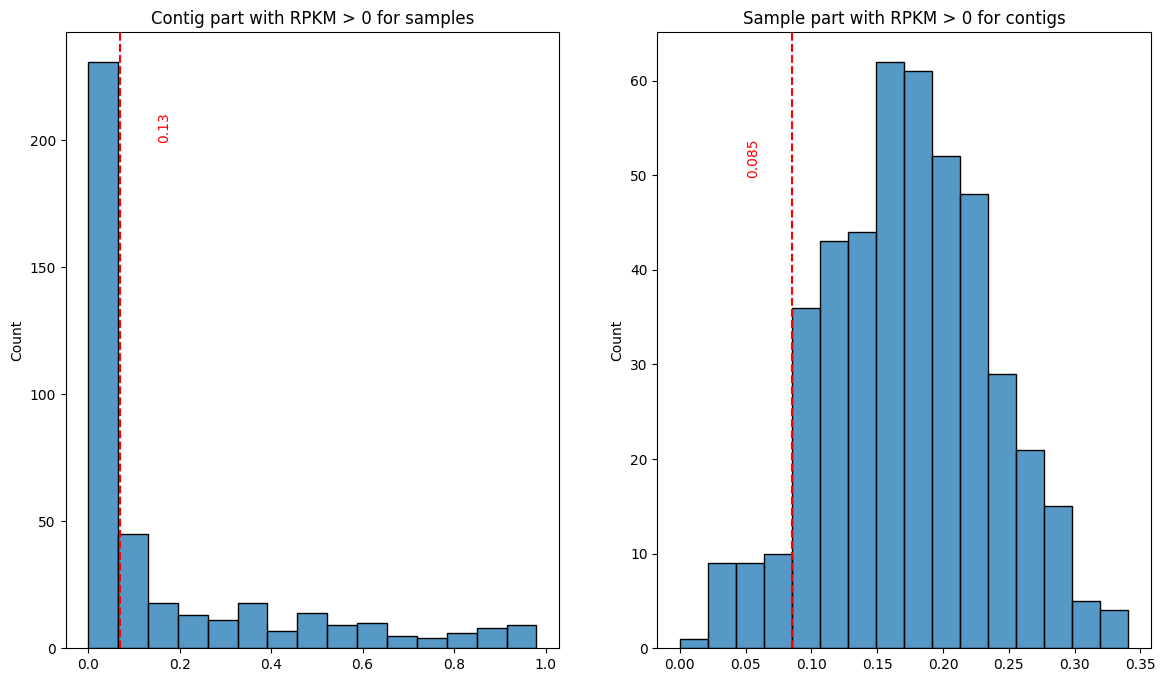

In [208]:
# Explore the samples and loci with bed coverage

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
contig_pos_coverage = (df > 0).sum(axis=1) / df.shape[1]

sns.histplot(contig_pos_coverage, ax=ax1)
ax1.axvline(x=0.07, color='red', ls='--')
ax1.text(0.15, 200, '0.13', rotation=90, color='r')
ax1.set_title('Contig part with RPKM > 0 for samples')
sample_pos_coverage = (df > 0).sum(axis=0) / df.shape[0]
sns.histplot(sample_pos_coverage, ax=ax2)
ax2.axvline(x=0.085, color='red', ls='--', label='0,05')
ax2.text(0.05, 50, '0.085', rotation=90, color='r')
ax2.set_title('Sample part with RPKM > 0 for contigs')

Text(0.5, 1.0, 'RPKM Hist')

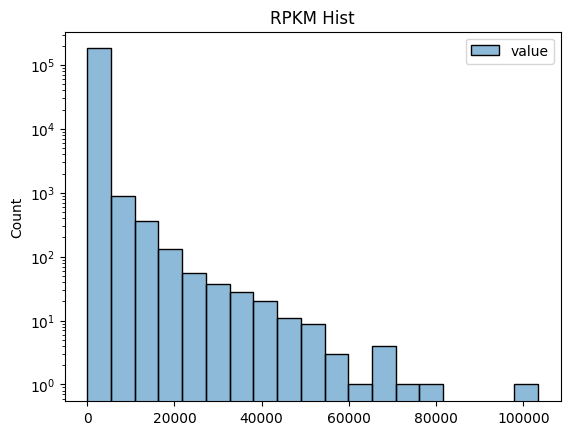

In [209]:
# Overall RPKM distribution
sns.histplot(df.astype('float').melt())
plt.yscale('log')
plt.title('RPKM Hist')


In [210]:
df = df.loc[contig_pos_coverage[contig_pos_coverage > 0.1].index] # Filter loci with coverage > 0.1 
df = df.loc[:, sample_pos_coverage[sample_pos_coverage >= 0.05].index] # Filter samples with coverage >= 0.05
df = df[df.index.isin(locus_info['seq_id'])]
df = df.T.join(meta.set_index('sample_name'))
df.shape

(434, 12)

In [211]:
df = df[df['sex'].isin(['male', 'female'])] # Lets focus on legimit sex type
df = df[df['diet_type'] != 'Omnivore but do not eat red meat'] # Small number of samples
df = df[df['bmi_cat'] != 'not provided']
df = df[df['age_cat'] != 'not provided']
df = df[df['age_cat'] != 'teen'] # Small number of samlpes
df[df.columns[df.columns.str.contains('MGYG')]] = df[df.columns[df.columns.str.contains('MGYG')]].astype('float')
df.shape


(418, 12)

<Axes: xlabel='pathway_coverage', ylabel='Pathway'>

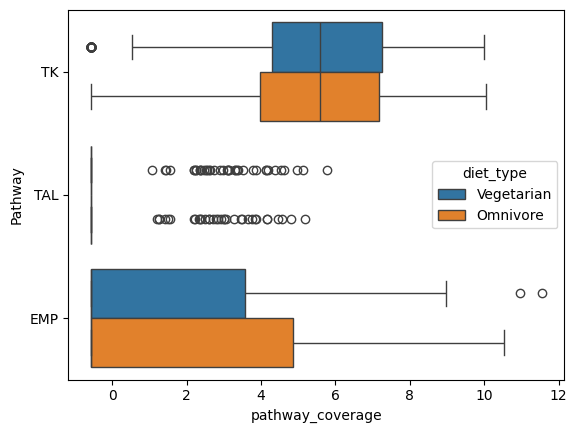

In [212]:
# PhylumPathway Analysis
pathway_data = test[test.columns[test.columns.str.contains('MGYG')]].T
pathway_data = pathway_data.join(locus_info.set_index('seq_id'))
pathway_data = pathway_data[pathway_data['Pathway'].isin(['TK', 'EMP', 'TAL'])]
phylum_path_data = pathway_data.groupby(['Species', 'Pathway'])[pathway_data.columns[pathway_data.columns.str.contains('10317')]].sum().T
melted_species_data = phylum_path_data.T.reset_index().melt(
    id_vars=['Species','Pathway'],
    value_name='pathway_coverage',
    var_name='sample_name').merge(meta)
# Calculate pseudocount as minimum positive pathway_coverage value
positive_coverages = melted_species_data.loc[melted_species_data['pathway_coverage'] > 0, 'pathway_coverage']

pseudocount = positive_coverages.min()

# Add pseudocount/2 to pathway_coverage, then take natural log
# Convert to float explicitly to avoid issues
melted_species_data['pathway_coverage'] = np.log(
    melted_species_data['pathway_coverage'].astype(float) + pseudocount / 2
)


sns.boxplot(melted_species_data, x='pathway_coverage', y='Pathway', hue='diet_type')

## OLS with species

In [217]:
# Define the OLS regression model with interaction between diet and species
species_model = smf.ols(
    formula='pathway_coverage ~ diet_type * C(Species, Treatment(reference="s__Bacteroides caccae")) + age_cat + bmi_cat + sex',
    data=melted_species_data
).fit()

# Show the detailed summary
species_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                 Results: Ordinary least squares
=================================================================================================================================================================
Model:                                              OLS                                             Adj. R-squared:                                    0.565     
Dependent Variable:                                 pathway_coverage                                AIC:                                               12954.8360
Date:                                               2025-05-23 13:40                                BIC:                                               13092.4081
No. Observations:                                   2926                                            Log-Likelihood:                                    -6454.4   
Df Model:                                           22                                              F-statistic:                                       173.8     
Df Residuals:                                       2903                                            Prob (F-statistic):                                0.00      
R-squared:                                          0.568                                           Scale:                                             4.8636    
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                         5.3175   0.1678  31.6985 0.0000  4.9886  5.6465
diet_type[T.Vegetarian]                                                                                          -0.0955   0.2219  -0.4301 0.6671 -0.5306  0.3397
C(Species, Treatment(reference="s__Bacteroides caccae"))[T.s__Bacteroides acidifaciens]                          -1.8561   0.2052  -9.0451 0.0000 -2.2585 -1.4537
C(Species, Treatment(reference="s__Bacteroides caccae"))[T.s__Enterocloster aldenensis]                          -5.2604   0.2052 -25.6346 0.0000 -5.6627 -4.8580
C(Species, Treatment(reference="s__Bacteroides caccae"))[T.s__Escherichia coli_D]                                -3.1033   0.2052 -15.1229 0.0000 -3.5057 -2.7009
C(Species, Treatment(reference="s__Bacteroides caccae"))[T.s__Mediterraneibacter faecis]                          0.4773   0.2052   2.3258 0.0201  0.0749  0.8796
C(Species, Treatment(reference="s__Bacteroides caccae"))[T.s__Phocaeicola dorei]                                  3.2612   0.2052  15.8925 0.0000  2.8589  3.6636
C(Species, Treatment(reference="s__Bacteroides caccae"))[T.s__Phocaeicola sartorii]                              -1.7890   0.2052  -8.7183 0.0000 -2.1914 -1.3867
age_cat[T.30s]                                                                                                   -0.1581   0.1256  -1.2587 0.2082 -0.4044  0.0882
age_cat[T.40s]                                                                                                   -0.0831   0.1369  -0.6072 0.5438 -0.3516  0.1853
age_cat[T.50s]                                                                                                   -0.2183   0.1229  -1.7766 0.0757 -0.4591  0.0226
age_cat[T.60s]                                                                                                   -0.0539   0.1445  -0.3732 0.7090 -0.3373  0.2294
age_cat[T.70+]                                                                                                   -0.0083   0.188

/tmp/ipykernel_894336/3407291935.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['color_group'] = significant['Coef.'].apply(lambda x: 'Positive' if x > 0 else 'Negative')


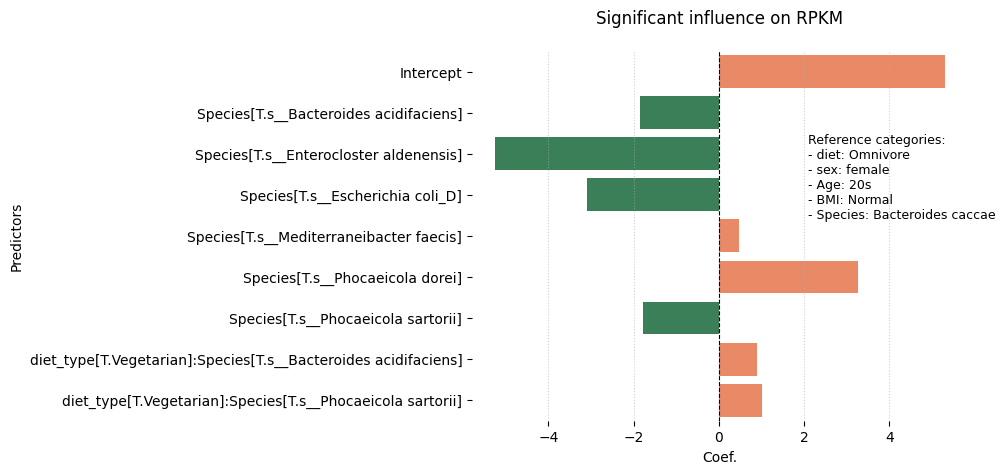

In [219]:
OLS_summary = species_model.summary2().tables[1]
OLS_summary = OLS_summary.reset_index(names='predictors')
OLS_summary['predictors'] = OLS_summary.predictors.str.replace('C(Species, Treatment(reference="s__Bacteroides caccae"))', 'Species')
OLS_summary
significant = OLS_summary[OLS_summary['P>|t|'] < 0.05]
ref_text = (
    "Reference categories:\n"
    "- diet: Omnivore\n"
    "- sex: female\n"
    "- Age: 20s\n"
    "- BMI: Normal\n"
    "- Species: Bacteroides caccae\n"
)
plt.figtext(0.65, 0.5, ref_text, ha="left", fontsize=9)

# Horizontal barplot
significant['color_group'] = significant['Coef.'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
sns.barplot(
    data=significant,
    x='Coef.',
    y='predictors',
    hue='color_group',
    orient='h',
    palette={'Positive': 'coral', 'Negative': 'seagreen'},
    dodge=False,
    legend=False
)
# Null line
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Labels
plt.title('Significant influence on RPKM', pad=20)
plt.xlabel('Coef.')
plt.ylabel('Predictors')
plt.grid(axis='x', linestyle=':', alpha=0.6)

# No spines
sns.despine(left=True, bottom=True)

plt.show()


